# Market risk lesson, practice
## Supplement 2021 - Conditional VaR

In the lesson we have seen that expected shortfall is defined like
$$
{\rm ES}_p[x]=E[-x \, {\rm s.t. } \, x\leq {\rm VaR}_p(X)]
$$
but during this exercise, to make comparison with VaR we will drop the minus sign, so we define:
$$
{\rm CVaR}_p[x]=E[x \, {\rm s.t. } \, x\leq {\rm VaR}_p(X)]
$$
and we will call CVaR the un-inverted expected shortfall.
Le us setup things like in the VaR exercise, backtest section:

In [1]:
from pandas_datareader import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import kurtosis
from scipy.stats import skew
sp500_btest = data.DataReader("XSPX.MI", 
                       start='2015-3-31', 
                       end='2021-3-31', 
                       data_source='yahoo')['Adj Close']
sp500_btest=sp500_btest.resample('W').last()
sp500_ylds_btest=np.log(sp500_btest).diff()[1:]

And let us calculate parametric and historical VaR:

In [2]:
TestYield_btest=[]
ParametricVaR_btest=[]
for i in range(159,314):
    BaseYields=sp500_ylds_btest[(i-159):(i-2)]
    TestYield_btest.append(sp500_ylds_btest[i-1])
    ParametricVaR_btest.append(np.std(BaseYields)*norm.ppf(0.05))
HSVaR_btest=[]
for i in range(159,314):
    BaseYields=sp500_ylds_btest[(i-159):(i-2)]
    BaseYields=BaseYields-np.mean(BaseYields)
    HSVaR_btest.append(np.percentile(BaseYields,5))

Just to be sure everything is ok, let's draw a chart...

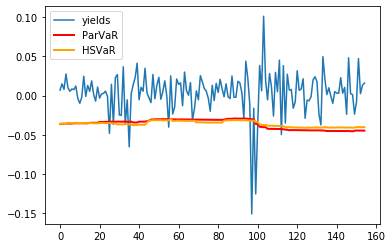

In [3]:
plt.plot(TestYield_btest,label="yields")
plt.plot(ParametricVaR_btest,color="red",lw=2,label="ParVaR")
plt.plot(HSVaR_btest,color="orange",lw=2,label="HSVaR")
plt.legend()

Ok, let us calculate historical simulation conditional VaR: we need to average things below VaR.

In [4]:
HSCVaR=[]
for i in range(159,314):
    BaseYields=sp500_ylds_btest[(i-159):(i-2)]
    BaseYields=BaseYields-np.mean(BaseYields)
    Z=np.array(BaseYields)
    HSVaR=np.percentile(Z,5)
    HSCVaR.append(np.mean(Z[Z<HSVaR]))

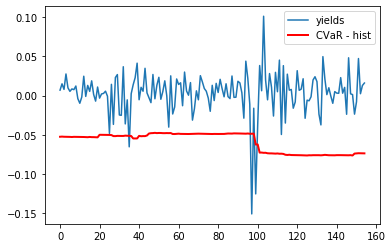

In [5]:
plt.plot(TestYield_btest,label="yields")
plt.plot(HSCVaR,color="red",lw=2,label="CVaR - hist")
plt.legend()

We can plot historical simulation VaR and CVaR: we see that CVaR is a little bit smoother, much less than you could expect: you're always relying on (the same) small number of samples in the tail of distribution!

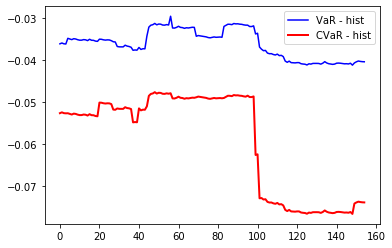

In [6]:
plt.plot(HSVaR_btest,color="blue",label="VaR - hist")
plt.plot(HSCVaR,color="red",lw=2,label="CVaR - hist")
plt.legend()

Can we calculate expected shorfall in the parametric case? For sure. In the parametric case we already know the distribution so:
$$
{\rm CVaR}_{par} = \frac{1}{\sqrt{2 \pi} \Phi(z) }\int\limits_{-\infty}^{z} x \exp (-x^2/2) dx = \frac{-\exp (-z^2/2)}{\sqrt{2 \pi} \Phi(z)} 
$$
In our case:
$$
\Phi(z)=0.05
$$
so:

In [7]:
-np.exp(-(norm.ppf(0.05)**2)/2)/((2*np.pi)**0.5)/0.05

-2.0627128075074253

So we can calculate the parametric conditional VaR with a factor:

In [8]:
ParametricCVaR=[]
for i in range(159,314):
    BaseYields=sp500_ylds_btest[(i-159):(i-2)]
    ParametricCVaR.append(np.std(BaseYields)*(-2.0627128))

Have a look of the differenc CVaRs:

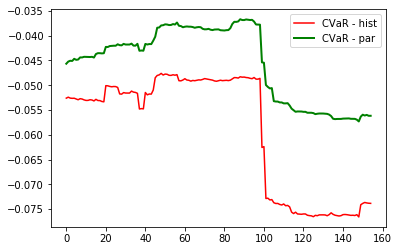

In [9]:
plt.plot(HSCVaR,color="red",label="CVaR - hist")
plt.plot(ParametricCVaR,color="green",lw=2,label="CVaR - par")
plt.legend()

Let's see CVaR compared to yields:

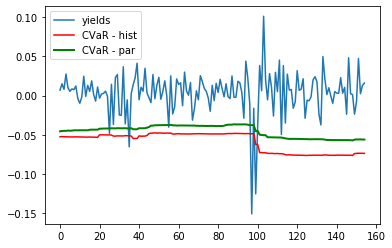

In [10]:
plt.plot(TestYield_btest,label="yields")
plt.plot(HSCVaR,color="red",label="CVaR - hist")
plt.plot(ParametricCVaR,color="green",lw=2,label="CVaR - par")
plt.legend()

As you can see absolute values are very different, but in the end of the day both approaches could be considered acceptable since both related VaR passed backtest. We are facing uncertainty on tail structure.